In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
from pathlib import Path
from functools import partial
from typing import Callable, List
import warnings
import sys

import albumentations as A
import pandas as pd
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models import mobilenet_v3_small
from torchvision import transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

sys.path.append('../src/')
from avg_video import avg_video

warnings.filterwarnings("ignore")

In [4]:
DATA_DIR = Path('../data/')
CLASSES = ["bridge_down", "bridge_up", "no_action", "train_in_out"]
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

In [5]:
train_clips = sum([list(DATA_DIR.joinpath("train", c).glob("*.mp4")) for c in CLASSES], [])
train_clips = pd.DataFrame([clip.parts[-2:] for clip in train_clips], columns=["label", "fname"])

train_clips.head()

,label,fname
0,bridge_down,67f2ef6e74a93504.mp4
1,bridge_down,b9badc8dd567155f.mp4
2,bridge_down,88c00402cdad6b36.mp4
3,bridge_down,d606865a8dce4179.mp4
4,bridge_down,ea1bf78e20cd4c63.mp4


In [6]:
train_clips.label.value_counts()

bridge_down     306
bridge_up        75
train_in_out     66
no_action        49
Name: label, dtype: int64

In [7]:
def read_clip(odir: Path,
              fname: str,
              start: int = 0,
              transposed: bool = True):
    """Прочесть ролик в массив."""

    cpr = cv2.VideoCapture(odir.joinpath(fname).as_posix())
    has_frame = True
    frames = []

    while has_frame:
        has_frame, frame = cpr.read()
        if has_frame:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if transposed:
                frame = np.moveaxis(frame, -1, 0).copy()

            frames.append(frame)
    cpr.release()
    return np.array(frames)[start:]

In [8]:
sample_clip = train_clips.sample(5, random_state=SEED).iloc[1]
sample_clip_path = DATA_DIR.joinpath("train", sample_clip.label)
clip = read_clip(sample_clip_path, sample_clip.fname, transposed=False)

In [9]:
clip.shape

(256, 240, 320, 3)

In [13]:
sample_clip_path

PosixPath('../data/train/bridge_down')

In [16]:
str(sample_clip_path) + '/' + str(sample_clip.fname)

'../data/train/bridge_downec45a34226c4d731.mp4'

In [24]:
sample_clip_path.joinpath(sample_clip.fname)

PosixPath('../data/train/bridge_down/ec45a34226c4d731.mp4')

In [53]:
clip_avg = avg_video(str(sample_clip_path.joinpath(sample_clip.fname)),
                     mode='average')


Processed frame 1/500


In [48]:
clip_avg.shape

(240, 320, 3)

In [49]:
clip[0].shape

(240, 320, 3)

In [50]:
sample_clip.label

'bridge_down'

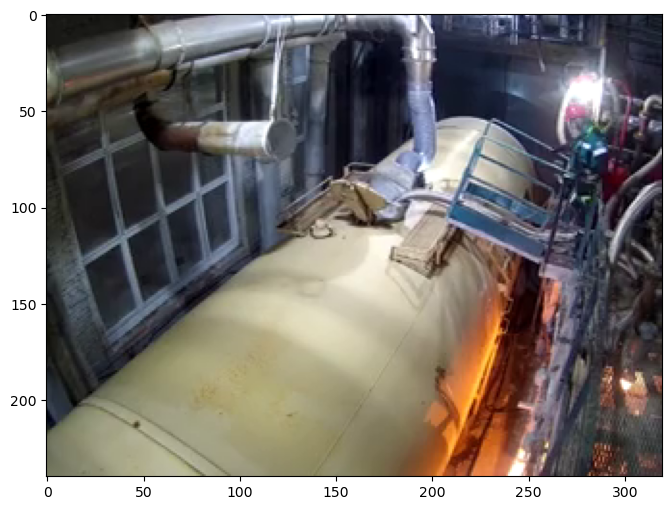

In [55]:
plt.figure(figsize=(8, 6))
plt.imshow(clip[255])
plt.grid(False)

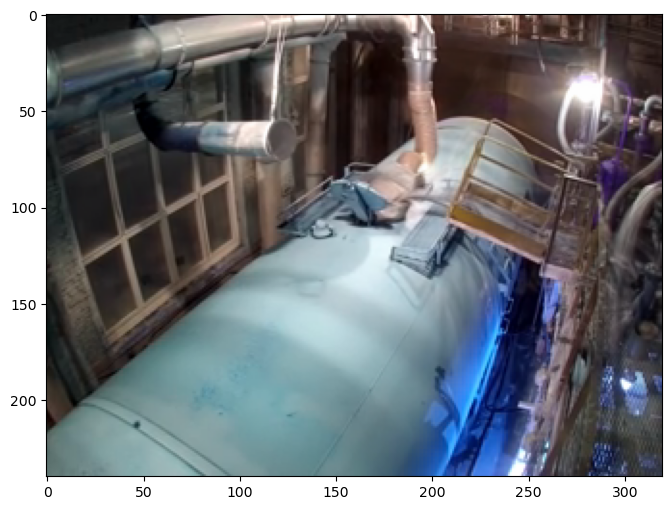

In [54]:
plt.figure(figsize=(8, 6))
plt.imshow(clip_avg)
plt.grid(False)

# Model

In [246]:
freeze_pretrained = True
num_epochs = 10
batch_size = 80
lr = 1e-3

In [227]:
model = mobilenet_v3_small(pretrained=True)

for params in model.parameters():
    params.requires_grad = freeze_pretrained

model.classifier[-1] = torch.nn.Linear(1024, len(CLASSES))
model.to(DEVICE)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [219]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [220]:
label2id = {CLASSES[i]: i for i in range(len(CLASSES))}

In [221]:
normalization = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [222]:
class VideoDataset(Dataset):
    def __init__(self, 
                 data: pd.DataFrame,
                 transforms: Callable = None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        fname = self.data.iloc[idx]['fname']
        label_str = self.data.iloc[idx]['label']
        clip_dir = DATA_DIR.joinpath("train", label_str)
        clip = read_clip(clip_dir, fname)
        label = label2id[label_str]

        if self.transforms:
            clip_path = clip_dir.joinpath(fname)
            clip = self.transforms(str(clip_path))
        clip = normalization(clip)

        return clip, label

In [223]:
train_data, val_data = train_test_split(train_clips,
                                        train_size=0.8,
                                        stratify=train_clips['label'],
                                        shuffle=True,
                                        random_state=SEED)

In [247]:
train_data.shape, val_data.shape

((396, 2), (100, 2))

In [251]:
train_dataset = VideoDataset(train_data, transforms=avg_video)
val_dataset = VideoDataset(val_data, transforms=avg_video)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [252]:
# Training loop
num_epochs = 10
preds = []
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()
        predicted = outputs.argmax(1)

    train_loss /= len(train_dataloader)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in val_dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update statistics
            val_loss += loss.item()
            predicted = outputs.argmax(1)
            preds.extend(list(predicted.cpu().numpy()))

    val_loss /= len(val_dataloader)
    
    print(f'Epoch: {epoch}, Train loss: {train_loss}, Val loss: {val_loss}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, Train loss: 1.5321871519088746, Val loss: 1.551765501499176
Epoch: 1, Train loss: 1.5266724109649659, Val loss: 1.5510624051094055
Epoch: 2, Train loss: 1.5152994394302368, Val loss: 1.5507338047027588


In [240]:
labels = val_data['labels'].map(label2id)

1.358886957168579

In [239]:
list(outputs.argmax(1).cpu().numpy())

[3, 0, 2, 0]